<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/inception_v2%2C_v3_(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1. 패키지 로드
---

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 2.9 MB/s 
     |████████████████████████████████| 37.1 MB 96 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
# 2. 논문 분석
---

 5 가지 중요 포인트 
* General Design Principles

* Factorizing Convolutions with Large Filter
Size


* Utility of Auxiliary Classifier

* Efficient Grid Size Reduction

* Model Regularization via Label Smoothing

## 1) General Design Principles

이거 인터넷에 사람들이 번역을 많이 해놨는데, 많이 틀리게들 번역해놨음.

이 원칙들은 명백한 증명에 의한 것이 아님.

* 1. Avoid representational bottlenecks
    > pooling을 크게크게 가져가지마라. representational bottleneck을 만든다. 특히 초반부 pooling을 크게하면 안 된다. 여기서 bottleneck은 여태 공부한 bottleblock 처럼 차원을 늘렸다 줄였다가 아님. pooling으로 크게 크게 이미지 사이즈를 줄여내는 것을 하지 말라는 것.

* 2. Higher dimensional representations are easier to process locally within a network
    > 고차원적인 표현정보들이 지역적으로 더 빨리 진행된다.
    
    > Increasing the activations per tile in a convolutional network allows for more disentangled features.

    > \>\> 한타일에 대해 활성화를 더 많이 할 수록 (필터수가 늘어날 수록) 풀린 정보(의미있는 feature)들을 얻기 쉽다.

* 3. Spatial aggregation can be done over lower dimensional embeddings without much or any loss in representational power
    > 이걸 사람들이 많이들 다르게 해석해 놓았음.
    
    > spatial aggregation은 3x3같은 conv연산을 의미하는 것이다. 왜냐하면 공간정보를 응축하는 행위이기 때문.

    > 그리고 lower dimensional embeddings는 저 차원의 공간에 대한 이야기. 즉 1x1 conv로 차원을 줄여놓은것.

    > 따라서 3x3같은 spatial aggregation 이 (dimension reduction을 통해) 작아진 lower dimensianal embeddings 위에 걱정없이 적용될 수 있다는 이야기이다.

    > 그 원인을 가정해보면, 채널 수를 묶을 때 그 인접한 unit들이 강한 상관 관계를 가지고 있기 때문에 이것들을 묶어서 다시 3x3같은 spatial aggregation을 한다면 별로 정보를 잃을 걱정을 안 해도된다는 이야기. 이런 채널수 reduction 후 공간응축(conv)는 걱정없이 계산량을 줄일 수 있는 좋은 방법

* 4. Balance the width and depth of the network
> 직관적으로 이해할 수 있다.

## 2) Factorizing Convolutions with Large Filter Size


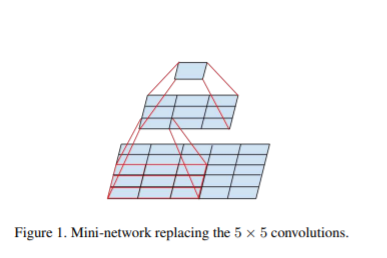

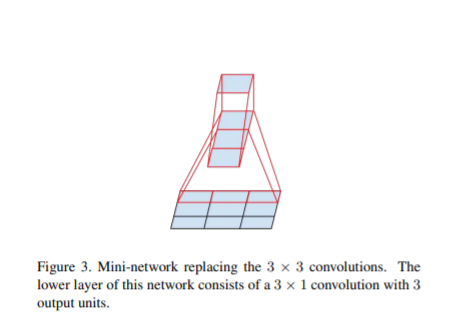

* 직관적으로 이해할 수 있다. 5x5 conv는 3x3conv 2개와 정확히 동일한 범위(receptive field)를 다룰 수 있다. 하지만 계산량은 25 vs 9 이다.

* 아래도 마찬가지. nxn은 1xn , nx1 로 분해가능하다. 이건 잘 생각해보면 2차원을 1차원의 두번으로 분해하는 것으로 이해 할 수 있다. 

* 이 과정들에 대해 두가지 의문점이 들 수 있는데,
        1. 표현력의 손실에 대한 의문
        2. 이것들의 목적이 linear 계산을 factorize하는 거라면 2단계의 줄이는 과정 중, 첫번째 과정의 activation이 여전히 선형이여야 하는 것 아닌가? 
    >  중간에 relu같은 걸 거치면 정확히 말하면 연속 과정이 아니라 선형성을 잃게 되는 것이기 때문, "선형성을 factorize하여 계산량을 줄이는는 것이 가중치x값 의 25개를 가중치x값 9개 두번으로 바꾸는 것이니까. 9개의 곱이 비선형성을 가지지 않고 선형성을 유지한채로 다시 계산에 들어가야하지 않겠냐?" 라고 생각 할 수 있음. 
   
    >  여기서 그 결과를 실험으로 확인해보니 그냥 ReLU쓰는 것이 모든 학습단계에서 유리했음. 표현력 손실에 대한 질문에는 답을 하지 않지만, 이런 gain들이  space of variations를 향상시킨다는 데서 기인한다는 것을 보니 표현력도 별로 손실되지 않는듯.
     > \>\> linear보다 ReLU가 더 유리한 현상은 채널 줄이기(1x1)에서도 비슷한 결과를 보임.

## 3) Utility of Auxiliary Classifier

* 지난 인셉션에서 구현했던 auxiliary classifier의 동기는 학습 초기 부분(하위 레이어)에 의미있는 gradient를 주려고 한 것. 따라서 이게 깊은 신경망에서 기울기 소멸 문제를 해결하여, 학습의 수렴에 도움이 되기를 바랬음.

* 연구 해보니까 초반부에서 이런 보조분류기가 수렴을 개선시키지 않음을 확인했고, 어느정도 정확도에 도달하고 나서야 보조분류기가 의미를 가짐. 따라서 하나를 지운다.

* 초반부 낮은 레벨의 특징을 뽑는데 도움이 되기를 바랬으나, 잘못되었다. 오히려 이런 보조분류기는 regularizer로 동작함.


## 4) Efficient Grid Size Reduction

* 이미지의 사이즈를 줄이는 과정(pooling)이 어떻게 적용되야 되는지에 대한 설명이다.

* 그림9를 보면 왼쪽은 풀링을 먼저하고 conv로 채널을 늘렸고, 오른쪽은 채널을 늘리는 conv를 하고 풀링을 하였다. 이는 단순히 계산해봐도 계산량과 파리미터수가 4배(논문 표현으로는 3배만큼 더) 차이난다. 하지만 pooling을 크게 확 해버리는 것은 계산량에서 유리하더라도 원칙 1에서 벗어난다. 즉, 표현력을 감소시킨다.

* 이런 성질들을 생각해서  계산량과 표현력을 둘 다 잡기위해 그림 10과 같은 inception module을 고안했다. 양뱡향으로 나눠서 conv와 pooling을 하고 concat하는 것이라 생각하면 된다.

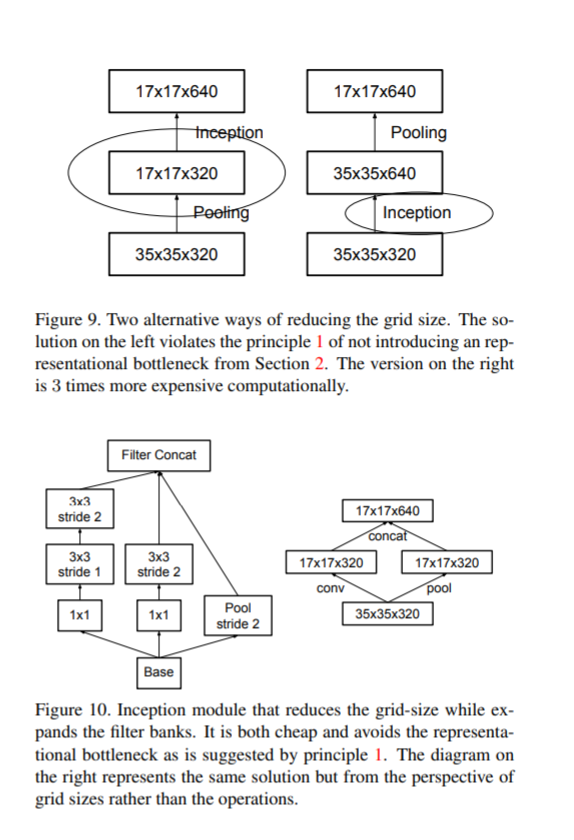

## 5) Model Regularization via Label Smoothing

* label smoothing으로 model regularization을 이뤘다. 이는 새로운 loss의 옵션에 대한 이야기이다. label-smoothing regularization 줄여서 LSR

* cross-entropy loss는 soft max의 결과에 negative log-likelihood를 이용한 loss이다. soft max는 확률을 알려주고 nll loss는 이 확률과 원래 타겟값(1과 0으로 원핫인코딩)을 비교하여 loss를 제공한다. 과정은 softmax로 나온 확률에 log를 씌운 후, 맞은 값에는 1을 곱하고 틀린값에는 0을 곱하는 log를 씌운채로 제공해 주는 것이다.

* 여기에 옵션을 주어서 원핫인코딩의 경우 틀리면 무조건 0인데, 1과 0의 너무 가혹한 학습이 이뤄지지 않게 어떤 사전 분포에 따라 곱하자는 것이다. 여기서는 uniform분포를 사전 분포로 사용하였다.

* 용어는 많지만 원핫인코딩의 하드한 결과를 소프트하게 바꾼다고 이해 할 수 있음. 그리고 직관적으로 생각해봐도. 1,0만으로 값을 낸다면 어느 부분에서 어떤 오차가 발생했는지 전혀 반영 할 수 없지만, 틀린값에 작은 값이라도 곱하여 soft target으로 바꿔준다면 그 틀린 값에 대해서도 학습이 이뤄질 수 있다.

* y_k였던 하드 타겟을 아래식을 통해서 바꿔준다. 가령 [0 , 1 ,0 , 0] 의 타겟을 [ 0.025, 0.925, 0.025, 0.025] 로 바꿔준다. 여기에서는 알파를 0.1로 사용하고 사전분포를 uniform으로 사용

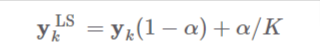


---


# 3. 구현


---

* 이 논문은 중간중간 실제 구현 내용이 자세히 나와있지 않다. 논문에는 model.txt 라는 파일에 설명을 넣었다고 했지만, 이 파일을 구할 수 가없다.
* 또한 논문에서 명시한 부분 말고는 padding을 전혀 안 했다고 하는데, 패딩이 없으면 사이즈가 다르게 나오는 부분이 존재한다.

* 파이토치의 구현을 찾아보려했지만 파이토치에도 inception v2, v3는 구현해 놓지 않았다.

* 텐서플로우의 구현을 찾아보았지만, 텐서플로우에서도 논문과 다르게 임의로 작성되어있다. 가령 5x5필터를 3x3 두개로 나누는 부분, 블럭의 반복 후 사이즈를 줄일 때 부분이 논문과 다르게 구현 되어있다. 

* 사람들이 구현해 놓은 것들을 찾아보았지만, 대두분 값이나 구조가 조금씩 다르다. 특히 중간중간 필터수를 줄였다 늘릴 때의 값은 완전히 다르다. 따라서 inception v1과 유사하게 필터수 비율을 조절한다.





## 기본구조 구현
인셉션에서 사용했던 기본구조를 이용.

하지만, v3는 너무 복잡하여서 모든 구조를 함수로 모듈화 시키기 어려움. 따라서 아래의 블럭으로 진행

In [ ]:
def conv_block(in_channels, out_channels, **kwargs) :
    """ 
    conv들이 기본적으로 ReLU를 가지고 있고,
    성능향상을 위해서 BN층도 추가하여 block으로 만든다.
    BN을 사용하므로 bias는 False로 둔다.
    """
    output = nn.Sequential(
       nn.Conv2d(in_channels, out_channels, bias=False, **kwargs),
       nn.BatchNorm2d(out_channels),
       nn.ReLU()
    )
    return output

## 블럭 구현

#### 1) Inception A (figure 5)

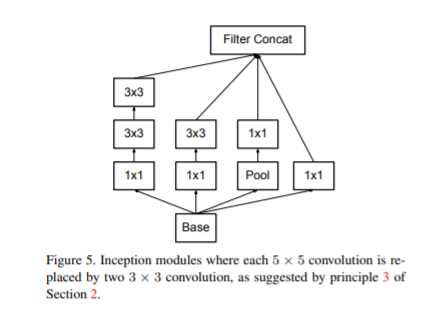

In [ ]:
class InceptionA(nn.Module):
    """
    channels : [1x1, 3x3reduce, 3x3, 5x5reduce, 5x5, pool proj]
    출력의 수를 리스트로 받아온다.(논문 표 대로)

    5x5는 여기서 3x3 두개로 쪼개진채로 사용할 것.

    """
    def __init__(self, input_channels, channel_list):
        super(InceptionA, self).__init__()

        self.output_channels = channel_list[0]+channel_list[2]+channel_list[4]+channel_list[5]

        # 1x1
        self.conv1 = conv_block(input_channels,channel_list[0],kernel_size =1)

        # 1x1, 3x3
        self.conv2 = nn.Sequential(
            conv_block(input_channels,channel_list[1],kernel_size=1),
            conv_block(channel_list[1], channel_list[2],kernel_size=3, padding = 'same')
        )

        # 1x1, 3x3, 3x3
        self.conv3 = nn.Sequential(
            conv_block(input_channels,channel_list[3],kernel_size=1),
            conv_block(channel_list[3],channel_list[3],kernel_size=3, padding = 'same'),
            conv_block(channel_list[3],channel_list[4],kernel_size=3, padding = 'same') 
        )

        # proj
        self.proj = nn.Sequential(
            nn.MaxPool2d(3, stride=1,  padding=1),
            conv_block(input_channels,channel_list[5],kernel_size=1)
        )


    def forward(self, input_tensor):        
        path1 = self.conv1(input_tensor)
        path2 = self.conv2(input_tensor)
        path3 = self.conv3(input_tensor)
        path4 = self.proj(input_tensor)

        output  = [path1,path2,path3,path4]
        

        return torch.cat(output, 1)
    
    def get_OC(self):
        '''
        아웃풋 채널 수 반환
        토치는 다음 인풋 사이즈를 반드시 넣어줘야 하므로
        편의를 위해 다음 conv 인자로 사용.
        '''
        return self.output_channels

       


model = InceptionA(192,[64,96,128,16,32,32]).to(device)
summary(model, (192,35,35))

model.get_OC()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 35, 35]          12,288
       BatchNorm2d-2           [-1, 64, 35, 35]             128
              ReLU-3           [-1, 64, 35, 35]               0
            Conv2d-4           [-1, 96, 35, 35]          18,432
       BatchNorm2d-5           [-1, 96, 35, 35]             192
              ReLU-6           [-1, 96, 35, 35]               0
            Conv2d-7          [-1, 128, 35, 35]         110,592
       BatchNorm2d-8          [-1, 128, 35, 35]             256
              ReLU-9          [-1, 128, 35, 35]               0
           Conv2d-10           [-1, 16, 35, 35]           3,072
      BatchNorm2d-11           [-1, 16, 35, 35]              32
             ReLU-12           [-1, 16, 35, 35]               0
           Conv2d-13           [-1, 16, 35, 35]           2,304
      BatchNorm2d-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


256

#### 2) Inception B (figure 6)

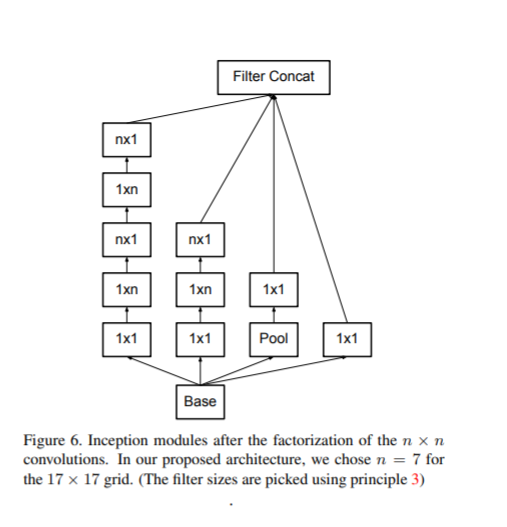

In [ ]:
mooddeell =  nn.Sequential(
    conv_block(64,80,kernel_size = 3)
).to(device)
summary(mooddeell, (64,73,73))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 80, 71, 71]          46,080
       BatchNorm2d-2           [-1, 80, 71, 71]             160
              ReLU-3           [-1, 80, 71, 71]               0
Total params: 46,240
Trainable params: 46,240
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.30
Forward/backward pass size (MB): 9.23
Params size (MB): 0.18
Estimated Total Size (MB): 10.71
----------------------------------------------------------------


In [ ]:
class InceptionB(nn.Module):
    """

    channels : [1x1, 3_reduce, 3_output, 5_reduce, 5_output, pool proj] 출력의 수를 리스트로 받아온다.
    3_reduce : 3층짜리에서 중간 필터수
    5_reduce : 5층짜리에서 중간 필터수
    ouput : 각 path당 목표 출력 필터수
    n : 논문의 1xn의 n
    
    """
    def __init__(self, input_channels, channel_list, n=7):
        super(InceptionB, self).__init__()

        self.output_channels = channel_list[0]+channel_list[2]+channel_list[4]+channel_list[5]
        
        # 1x1
        self.conv1 = conv_block(input_channels,channel_list[0],kernel_size =1)

        # 1x1, 1xn,  nx1
        self.conv2 = nn.Sequential(
            conv_block(input_channels,channel_list[1],kernel_size=1),
            conv_block(channel_list[1],channel_list[1],kernel_size=(1,n),padding = 'same'),
            conv_block(channel_list[1],channel_list[2],kernel_size=(n,1),padding = 'same'),            
        )

        # 1x1, 1xn , nx1, 1xn, nx1
        self.conv3 = nn.Sequential(
            conv_block(input_channels,channel_list[3],kernel_size=1),
            conv_block(channel_list[3],channel_list[3],kernel_size=(1,n),padding = 'same'),
            conv_block(channel_list[3],channel_list[3],kernel_size=(n,1),padding = 'same'), 
            conv_block(channel_list[3],channel_list[3],kernel_size=(1,n),padding = 'same'),
            conv_block(channel_list[3],channel_list[4],kernel_size=(n,1),padding = 'same')             
        )

        self.proj = nn.Sequential(
            nn.MaxPool2d(3, stride=1,  padding=1),
            conv_block(input_channels,channel_list[5],kernel_size=1)
        )




    def forward(self, input_tensor):        
        path1 = self.conv1(input_tensor)
        path2 = self.conv2(input_tensor)
        path3 = self.conv3(input_tensor)
        path4 = self.proj(input_tensor)

        output  = [path1,path2,path3,path4]
        

        return torch.cat(output, 1)
    
    def get_OC(self):
        '''
        아웃풋 채널 수 반환
        토치는 다음 인풋 사이즈를 반드시 넣어줘야 하므로
        편의를 위해 다음 conv 인자로 사용.
        '''
        return self.output_channels

       


model = InceptionB(192,[64,96,128,16,32,32], 7).to(device)
summary(model, (192,28,28))

model.get_OC()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          12,288
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 96, 28, 28]          18,432
       BatchNorm2d-5           [-1, 96, 28, 28]             192
              ReLU-6           [-1, 96, 28, 28]               0
            Conv2d-7           [-1, 96, 28, 28]          64,512
       BatchNorm2d-8           [-1, 96, 28, 28]             192
              ReLU-9           [-1, 96, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          86,016
      BatchNorm2d-11          [-1, 128, 28, 28]             256
             ReLU-12          [-1, 128, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           3,072
      BatchNorm2d-14           [-1, 16,

256

#### 3) Inception C (figure7)

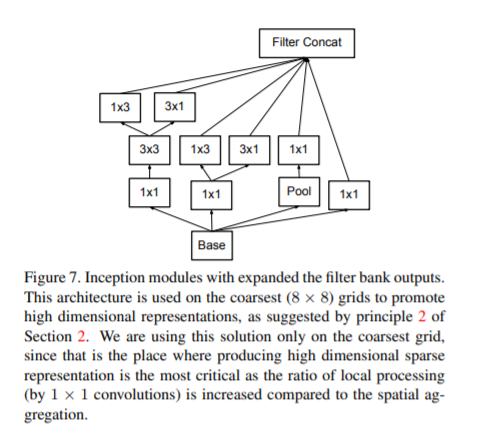

In [ ]:
class InceptionC(nn.Module):
    """

    channels : [1x1, 3_reduce, 3_output, 5_reduce, 5_output, pool proj] 출력의 수를 리스트로 받아온다.
    3_reduce : 3층짜리에서 중간 필터수
    5_reduce : 5층짜리에서 중간 필터수
    ouput : 각 path당 목표 출력 필터수

    
    """
    def __init__(self, input_channels, channel_list):
        super(InceptionC, self).__init__()

        self.output_channels = channel_list[0]+channel_list[2]+channel_list[4]+channel_list[5]
        
        # 1x1
        self.conv1 = conv_block(input_channels,channel_list[0],kernel_size =1)


        # 1x1, (1x3,  3x1)
        self.conv2 = conv_block(input_channels,channel_list[1],kernel_size=1)
        self.conv3 = conv_block(channel_list[1],channel_list[2]//2,kernel_size=(1,3), padding = 'same')
        self.conv4 = conv_block(channel_list[1],channel_list[2]//2,kernel_size=(3,1), padding = 'same')

        # 1x1, 3x3, (1x3,  3x1)
        self.conv5 = nn.Sequential(
            conv_block(input_channels,channel_list[3],kernel_size=1),
            conv_block(channel_list[3],channel_list[3],kernel_size=3, padding = 'same')         
        )

        self.conv6 = conv_block(channel_list[3],channel_list[4]//2,kernel_size=(1,3), padding = 'same')
        self.conv7 = conv_block(channel_list[3],channel_list[4]//2,kernel_size=(3,1), padding = 'same')

        # proj
        self.proj = nn.Sequential(
            nn.MaxPool2d(3, stride=1,  padding=1),
            conv_block(input_channels,channel_list[5],kernel_size=1)
        )        



    def forward(self, input_tensor):        
        # path1
        path1 = self.conv1(input_tensor)

        # path2
        path2 = self.conv2(input_tensor)
        path2_1 = self.conv3(path2)
        path2_2 = self.conv4(path2)

        # path3
        path3 = self.conv5(input_tensor)
        path3_1 = self.conv6(path3)
        path3_2 = self.conv7(path3)

        # path4
        path4 = self.proj(input_tensor)

        output  = [path1,path2_1,path2_2,path3_1,path3_2, path4]
        

        return torch.cat(output, 1)
    
    def get_OC(self):
        '''
        아웃풋 채널 수 반환
        토치는 다음 인풋 사이즈를 반드시 넣어줘야 하므로
        편의를 위해 다음 conv 인자로 사용.
        '''
        return self.output_channels

       


model = InceptionA(192,[64,96,128,16,32,32]).to(device)
summary(model, (192,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          12,288
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 96, 28, 28]          18,432
       BatchNorm2d-5           [-1, 96, 28, 28]             192
              ReLU-6           [-1, 96, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         110,592
       BatchNorm2d-8          [-1, 128, 28, 28]             256
              ReLU-9          [-1, 128, 28, 28]               0
           Conv2d-10           [-1, 16, 28, 28]           3,072
      BatchNorm2d-11           [-1, 16, 28, 28]              32
             ReLU-12           [-1, 16, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           2,304
      BatchNorm2d-14           [-1, 16,

#### 3) Efficient Grid Size Reduction (figure10)
효율좋게 줄이는 법 

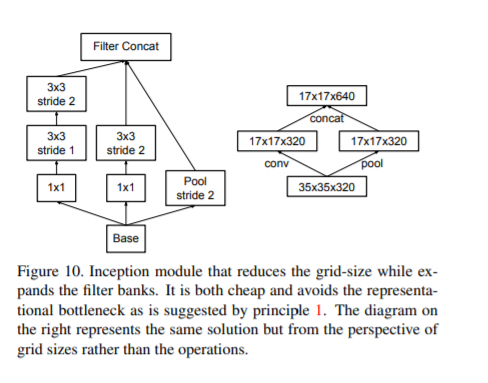

In [ ]:
class SizeReduction(nn.Module):
    """

    channels : [ reduce 1, output 1, reduce2, output2] 출력의 수를 리스트로 받아온다.
    reduce : 중간 필터수
    ouput : 각 path당 목표 출력 필터수

    
    """
    def __init__(self, input_channels, channel_list):
        super(SizeReduction, self).__init__()

        self.output_channels = channel_list[1]+channel_list[3] + input_channels//2

        # 1x1 3x3/2
        self.conv1 = nn.Sequential(
            conv_block(input_channels,channel_list[0],kernel_size=1, padding = 'same'),
            conv_block(channel_list[0],channel_list[1],kernel_size=3, stride =2 )
        )

        # 1x1, 3x3, 3x3/2
        self.conv2 = nn.Sequential(
            conv_block(input_channels,channel_list[2],kernel_size=1),
            conv_block(channel_list[2],channel_list[2],kernel_size=3, stride =1, padding = 'same' ),
            conv_block(channel_list[2],channel_list[3],kernel_size=3, stride =2 ),
        )


        # proj
        self.proj =  nn.MaxPool2d(3, stride=2)


    def forward(self, input_tensor):        

        path1 = self.conv1(input_tensor)
        path2 = self.conv2(input_tensor)
        path3 = self.proj(input_tensor)
        output  = [path1,path2,path3]
        

        return torch.cat(output, 1)
    
    def get_OC(self):
        '''
        아웃풋 채널 수 반환
        토치는 다음 인풋 사이즈를 반드시 넣어줘야 하므로
        편의를 위해 다음 conv 인자로 사용.
        '''
        return self.output_channels

       


#### 4) Auxiliary_module


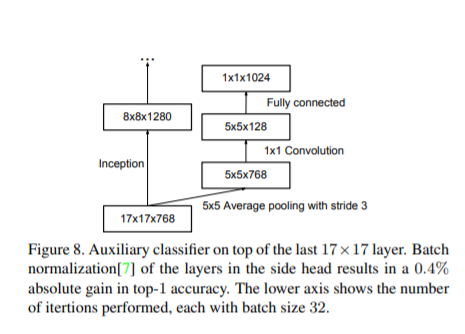

In [ ]:
class AuxiliaryModule(nn.Module):
    ''' AuxiliaryModule을 만들어서 반환해준다'''
    def __init__(self, input_channels, num_classes=1000):
        super(AuxiliaryModule, self).__init__()        
        
        self.auxi_module = nn.Sequential(
            # 5x5 + 3(V) avgpool
            nn.AvgPool2d(5,3),
            
            # 1x1 + 1(S) conv
            conv_block(input_channels,128,kernel_size=1),

            # FC
            nn.Flatten(),
            nn.Linear(3200,1024, bias =False),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            # 0.7 dropout
            nn.Dropout(0.7),

            #FC
            nn.Linear(1024, num_classes)

            #nn.Softmax()

            # 원래는 소프트 맥스가 있지만, 우리는 loss로 crossentropy를 사용할 것이기에 생략
            # crossentropy에 softmax가 포함되어있다.
        )


    def forward(self, input_tensor):
        return self.auxi_module(input_tensor)




#### 5) bottom


In [ ]:
class Bottom(nn.Module):
    """
    bottom 구현

    """
    def __init__(self):
        super(Bottom, self).__init__()
                
        self.bottom = nn.Sequential(
            conv_block(3,32,kernel_size = 3, stride = 2 ),
            conv_block(32,32,kernel_size = 3, stride = 1 ),
            conv_block(32,64,kernel_size = 3, padding = 'same' ),
            nn.MaxPool2d(3,2),
            conv_block(64,80,kernel_size = 3, stride = 1 ),
            conv_block(80,192,kernel_size = 3, stride = 2 ),
            conv_block(192,288,kernel_size = 3, padding = 'same') 
        )

    def forward(self, input_tensor):        

        return self.bottom(input_tensor)
    

       


model = Bottom().to(device)
summary(model, (3,299,299))
print(model)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
              ReLU-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
              ReLU-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 71, 71]          46,080
      BatchNorm2d-12           [-1, 80, 71, 71]             160
             ReLU-13           [-1, 80, 71, 71]               0
           Conv2d-14          [-1, 192,

## loss 구현(label smoothing)
cross entropy loss label smoothing


찾아보니 파이토치는 커스텀 로스도 쉽게 구현 가능하다.


* 논문에서 제시한 최종 식을 통해서 직관적으로 구현해보자. H는 cross entropy loss이고  H=CE 식은 아래와 같다. 결국 최종 식의 결과는 H(q,p) 와 H(u,p) 로 이루어져있다.

    > 여기서 결국 p분포와 q분포의 CE를 구하고, u분포와 p분포의 CE를 구해서 smoothing 파라미터와 연산하면 원하는 loss함수가 만들어진다. 따라서 이에 맞게 텐서의 형식을 맞추기만 하면 된다.

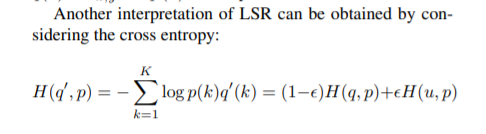

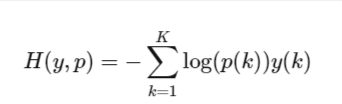

In [ ]:
z = torch.rand(64, 5, requires_grad=True)
print(z)

tensor([[0.2953, 0.7164, 0.3430, 0.5520, 0.9100],
        [0.8291, 0.7445, 0.5791, 0.0844, 0.2187],
        [0.7853, 0.1264, 0.1192, 0.3232, 0.1955],
        [0.1068, 0.2813, 0.7866, 0.7950, 0.5958],
        [0.9495, 0.9118, 0.3047, 0.9464, 0.7227],
        [0.2098, 0.7308, 0.5233, 0.6037, 0.5970],
        [0.5750, 0.6851, 0.2724, 0.8931, 0.0616],
        [0.5172, 0.2464, 0.5413, 0.3831, 0.9541],
        [0.5697, 0.6512, 0.7325, 0.8538, 0.3717],
        [0.2042, 0.2995, 0.1368, 0.4901, 0.3772],
        [0.4037, 0.3066, 0.6152, 0.9794, 0.4446],
        [0.7436, 0.3330, 0.5879, 0.9605, 0.7206],
        [0.0258, 0.1450, 0.2488, 0.0555, 0.2217],
        [0.8630, 0.5549, 0.5786, 0.2014, 0.3514],
        [0.5220, 0.6450, 0.7931, 0.7890, 0.5211],
        [0.4896, 0.8054, 0.3823, 0.2711, 0.2999],
        [0.3013, 0.5184, 0.9952, 0.7608, 0.3575],
        [0.0940, 0.1533, 0.9242, 0.1762, 0.0731],
        [0.6783, 0.2367, 0.0492, 0.4738, 0.7436],
        [0.2602, 0.5777, 0.9067, 0.8195, 0.7014],


In [ ]:
y = torch.randint(5, (64,)).long()
print(y)

tensor([1, 1, 1, 4, 1, 0, 4, 4, 1, 4, 4, 4, 4, 0, 1, 1, 0, 4, 3, 2, 2, 2, 3, 0,
        0, 2, 1, 4, 1, 4, 2, 2, 4, 3, 0, 1, 0, 2, 1, 2, 3, 2, 0, 4, 0, 3, 2, 4,
        0, 4, 3, 4, 0, 4, 2, 1, 1, 2, 0, 1, 4, 3, 3, 3])


In [ ]:
z.shape

torch.Size([64, 5])

In [ ]:
CC= LSRCrossEntropy()

In [ ]:
los = CC(z,y)

In [ ]:
los.

104.98980712890625

In [ ]:
F.cross_entropy(z, y)

tensor(1.6405, grad_fn=<NllLossBackward>)

In [ ]:
class LSRCrossEntropy(nn.Module):
    """
    LSR_CE의 배치단위 sum을 출력.
    """
    def __init__(self,smoothing_param=0.1):
        super(LSRCrossEntropy, self).__init__()
        self.param = smoothing_param
    def forward(self, pred, label):

        # 먼저, H(q,p)는 F.cross_entropy(p, q)로 쉽게 구할 수 있음
        H_qp = F.cross_entropy(pred, label, reduction = 'sum')
                
        # H(u,p)도 F.cross_entropy를 쓰고 싶지만
        # F.cross_entropy는 분포를 받지 않고 타겟의 정답 레이블만 받는 형식.
        # u는 균등분포. 즉, log_softmax에 클래스크기로 나누고 행별로 합을 구하는 것과 같다.
        H_up = (-F.log_softmax(pred, dim =1)/pred.shape[1]).sum(dim=1).sum()

        return (1-self.param)*H_qp + self.param*H_up

## inception v3 구현

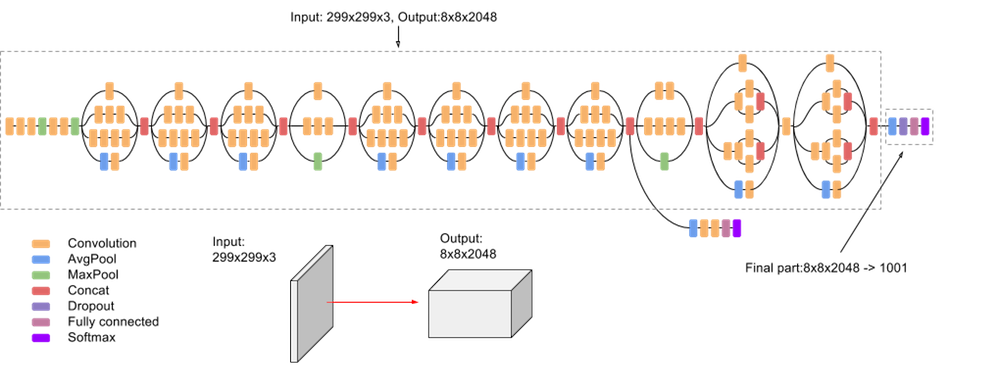

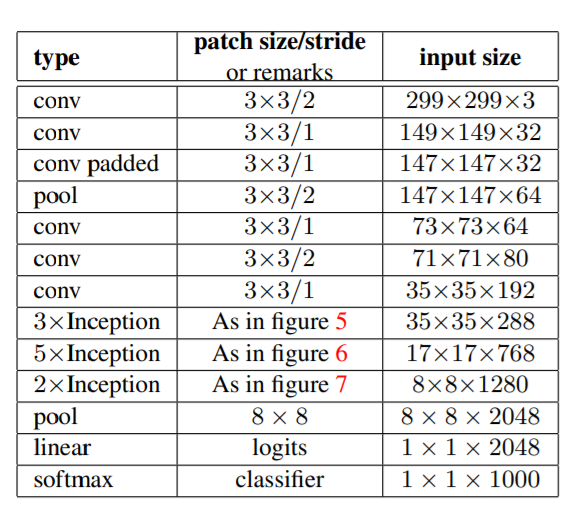

* 처음 그림은 구글 클라우드 TPU 사이트에서 가져왔는데, 논문이랑 구현이 다르다. 


* 모듈의 구성이나 inception 모듈 수, 층 수등등 조금씩 다르다. 논문에 최대한 맞춰서 구현해보자.

In [ ]:
class InceptionV3(nn.Module):
    ''' InceptionV3 model을 만들어서 반환해준다'''
    def __init__(self, num_classes=1000):
        super(InceptionV3, self).__init__()        

        self.bottom = Bottom()
        self.inceptionA_set = nn.Sequential(
            InceptionA(288, [72,72,144,18,36,36]),
            InceptionA(288, [72,72,144,18,36,36]),
            InceptionA(288, [72,72,144,18,36,36])
        )

        self.size1= SizeReduction(288, [120,240,120,240])

        self.inceptionB_set = nn.Sequential(
            InceptionB(768, [192,192,384,48,96,96]),
            InceptionB(768, [192,192,384,48,96,96]),
            InceptionB(768, [192,192,384,48,96,96]),
            InceptionB(768, [192,192,384,48,96,96]),
            InceptionB(768, [192,192,384,48,96,96])
        )

        self.size2= SizeReduction(768, [128,256,128,256])

        self.inceptionC_set = nn.Sequential(
            InceptionC(1280, [320,320,640,80,160,160]),
            InceptionC(1280, [512,512,1024,128,256,256])
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(2048, num_classes)
        )

        self.auxi = AuxiliaryModule(768,num_classes)


        self._initialize_weights()



    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def forward(self, input_tensor):
        x = self.bottom(input_tensor)
        
        x = self.inceptionA_set(x)
        x = self.size1(x)
        x = self.inceptionB_set(x)
        
        aux = self.auxi(x)
        
        x = self.size2(x)
        x = self.inceptionC_set(x)

        x = self.classifier(x)

        if self.training:
            return x, aux
        else:
            return x 


In [ ]:
# 모델 확인
model = InceptionV3().to(device)
summary(model, (3,299,299))
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
              ReLU-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
              ReLU-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 71, 71]          46,080
      BatchNorm2d-12           [-1, 80, 71, 71]             160
             ReLU-13           [-1, 80, 71, 71]               0
           Conv2d-14          [-1, 192,

---
# 4. 데이터 전처리
---

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
labels.shape

torch.Size([7])

(3, 96, 96)
torch.Size([3, 96, 96])


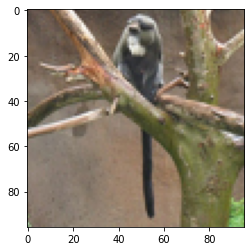

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

# totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


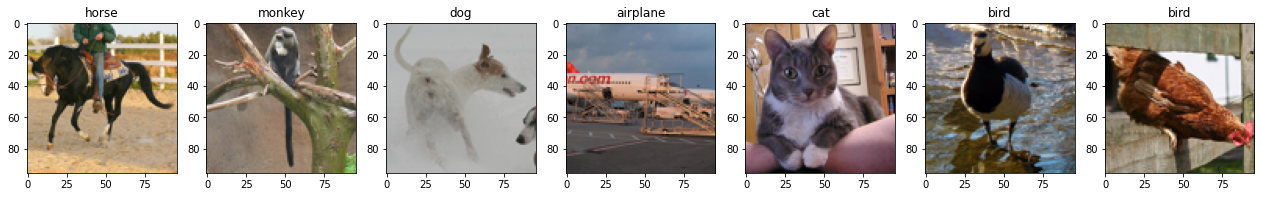

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.


            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

* 실험과정에서 성능이 좋지않아서 논문과 다른 장치들을 넣었음.

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    A.Resize(299,299),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    A.Resize(299,299),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 64
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




---
# 5. 학습 및 평가
---

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 lossfunc은 sum이용.
        # 일반 학습과 달리 auxi 블럭을 추가했기 때문에 이 부분에서 output이 3갈래로나옴.
        output, aux = model(images)
        sum_output_loss = criterion(output, target)
        sum_aux_loss = criterion(aux, target)
 

        # 논문에서 aux는 weight를 가진다고 제시함.
        sum_loss = sum_output_loss + 0.3*sum_aux_loss

        
        loss = sum_loss/len(target)        
     


        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []
    avg_train_accuracy = []
    avg_val_accuracy = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        avg_train_accuracy.append(train_accuracy)
        avg_val_accuracy.append(val_accuracy)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses,  avg_train_accuracy , avg_val_accuracy


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = InceptionV3(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
# criterion = nn.CrossEntropyLoss(reduction='sum')
criterion  = LSRCrossEntropy()

# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:
model, train_loss, val_loss ,train_accuracy ,val_accuracy= fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

Epoch: 1. Train.: 100%|██████████| 125/125 [01:43<00:00,  1.20it/s]


[1] Train Loss: 2.8486, Accuracy: 18.25%


Epoch: 1. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


[1] Validation Loss: 2.0211, Accuracy: 25.24%
Validation loss decreased (inf --> 2.021067).



Epoch: 2. Train.: 100%|██████████| 125/125 [01:47<00:00,  1.16it/s]


[2] Train Loss: 2.5714, Accuracy: 27.29%


Epoch: 2. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


[2] Validation Loss: 2.0039, Accuracy: 26.66%
Validation loss decreased (2.021067 --> 2.003874).



Epoch: 3. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[3] Train Loss: 2.4680, Accuracy: 30.80%


Epoch: 3. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[3] Validation Loss: 1.7922, Accuracy: 35.72%
Validation loss decreased (2.003874 --> 1.792159).



Epoch: 4. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[4] Train Loss: 2.4157, Accuracy: 33.74%


Epoch: 4. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


[4] Validation Loss: 1.7525, Accuracy: 38.56%
Validation loss decreased (1.792159 --> 1.752511).



Epoch: 5. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[5] Train Loss: 2.3651, Accuracy: 35.84%


Epoch: 5. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[5] Validation Loss: 1.7772, Accuracy: 37.50%
EarlyStopping counter: 1 out of 15



Epoch: 6. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[6] Train Loss: 2.3320, Accuracy: 37.12%


Epoch: 6. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


[6] Validation Loss: 1.6557, Accuracy: 45.00%
Validation loss decreased (1.752511 --> 1.655674).



Epoch: 7. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[7] Train Loss: 2.2951, Accuracy: 38.79%


Epoch: 7. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[7] Validation Loss: 1.6512, Accuracy: 44.14%
Validation loss decreased (1.655674 --> 1.651163).



Epoch: 8. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[8] Train Loss: 2.2476, Accuracy: 41.70%


Epoch: 8. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[8] Validation Loss: 1.6192, Accuracy: 46.90%
Validation loss decreased (1.651163 --> 1.619184).



Epoch: 9. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[9] Train Loss: 2.2333, Accuracy: 42.35%


Epoch: 9. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[9] Validation Loss: 1.6188, Accuracy: 45.90%
Validation loss decreased (1.619184 --> 1.618803).



Epoch: 10. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[10] Train Loss: 2.1886, Accuracy: 43.90%


Epoch: 10. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[10] Validation Loss: 1.5770, Accuracy: 48.98%
Validation loss decreased (1.618803 --> 1.577023).



Epoch: 11. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[11] Train Loss: 2.1804, Accuracy: 44.17%


Epoch: 11. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


[11] Validation Loss: 1.5653, Accuracy: 49.96%
Validation loss decreased (1.577023 --> 1.565335).



Epoch: 12. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[12] Train Loss: 2.1403, Accuracy: 46.20%


Epoch: 12. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[12] Validation Loss: 1.5809, Accuracy: 48.22%
EarlyStopping counter: 1 out of 15



Epoch: 13. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[13] Train Loss: 2.1268, Accuracy: 46.65%


Epoch: 13. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[13] Validation Loss: 1.6564, Accuracy: 45.62%
EarlyStopping counter: 2 out of 15



Epoch: 14. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[14] Train Loss: 2.0959, Accuracy: 48.44%


Epoch: 14. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


[14] Validation Loss: 1.4961, Accuracy: 53.42%
Validation loss decreased (1.565335 --> 1.496051).



Epoch: 15. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[15] Train Loss: 2.0757, Accuracy: 49.73%


Epoch: 15. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


[15] Validation Loss: 1.4753, Accuracy: 55.16%
Validation loss decreased (1.496051 --> 1.475262).



Epoch: 16. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[16] Train Loss: 2.0445, Accuracy: 50.14%


Epoch: 16. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[16] Validation Loss: 1.4645, Accuracy: 55.70%
Validation loss decreased (1.475262 --> 1.464543).



Epoch: 17. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[17] Train Loss: 2.0164, Accuracy: 51.95%


Epoch: 17. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


[17] Validation Loss: 1.4326, Accuracy: 56.82%
Validation loss decreased (1.464543 --> 1.432579).



Epoch: 18. Train.: 100%|██████████| 125/125 [01:47<00:00,  1.16it/s]


[18] Train Loss: 1.9896, Accuracy: 52.99%


Epoch: 18. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[18] Validation Loss: 1.4319, Accuracy: 56.90%
Validation loss decreased (1.432579 --> 1.431901).



Epoch: 19. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[19] Train Loss: 1.9681, Accuracy: 53.09%


Epoch: 19. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


[19] Validation Loss: 1.4278, Accuracy: 57.16%
Validation loss decreased (1.431901 --> 1.427768).



Epoch: 20. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[20] Train Loss: 1.9492, Accuracy: 54.46%


Epoch: 20. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[20] Validation Loss: 1.4002, Accuracy: 58.46%
Validation loss decreased (1.427768 --> 1.400171).



Epoch: 21. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[21] Train Loss: 1.9281, Accuracy: 55.29%


Epoch: 21. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[21] Validation Loss: 1.4054, Accuracy: 58.48%
EarlyStopping counter: 1 out of 15



Epoch: 22. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[22] Train Loss: 1.9116, Accuracy: 55.26%


Epoch: 22. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


[22] Validation Loss: 1.4274, Accuracy: 56.92%
EarlyStopping counter: 2 out of 15



Epoch: 23. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[23] Train Loss: 1.8900, Accuracy: 56.24%


Epoch: 23. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[23] Validation Loss: 1.4236, Accuracy: 58.08%
EarlyStopping counter: 3 out of 15



Epoch: 24. Train.: 100%|██████████| 125/125 [01:47<00:00,  1.16it/s]


[24] Train Loss: 1.8621, Accuracy: 57.15%


Epoch: 24. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[24] Validation Loss: 1.3291, Accuracy: 61.40%
Validation loss decreased (1.400171 --> 1.329070).



Epoch: 25. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[25] Train Loss: 1.8545, Accuracy: 58.21%


Epoch: 25. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[25] Validation Loss: 1.3494, Accuracy: 61.14%
EarlyStopping counter: 1 out of 15



Epoch: 26. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[26] Train Loss: 1.8287, Accuracy: 59.12%


Epoch: 26. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[26] Validation Loss: 1.3238, Accuracy: 62.30%
Validation loss decreased (1.329070 --> 1.323786).



Epoch: 27. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[27] Train Loss: 1.8182, Accuracy: 58.83%


Epoch: 27. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[27] Validation Loss: 1.3295, Accuracy: 62.22%
EarlyStopping counter: 1 out of 15



Epoch: 28. Train.: 100%|██████████| 125/125 [01:47<00:00,  1.16it/s]


[28] Train Loss: 1.7985, Accuracy: 60.71%


Epoch: 28. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[28] Validation Loss: 1.3495, Accuracy: 62.34%
EarlyStopping counter: 2 out of 15



Epoch: 29. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[29] Train Loss: 1.7782, Accuracy: 60.56%


Epoch: 29. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[29] Validation Loss: 1.3547, Accuracy: 60.78%
EarlyStopping counter: 3 out of 15



Epoch: 30. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[30] Train Loss: 1.7591, Accuracy: 61.50%


Epoch: 30. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[30] Validation Loss: 1.3172, Accuracy: 64.04%
Validation loss decreased (1.323786 --> 1.317195).



Epoch: 31. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[31] Train Loss: 1.7267, Accuracy: 62.61%


Epoch: 31. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[31] Validation Loss: 1.3202, Accuracy: 63.50%
EarlyStopping counter: 1 out of 15



Epoch: 32. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[32] Train Loss: 1.7246, Accuracy: 62.48%


Epoch: 32. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[32] Validation Loss: 1.2540, Accuracy: 66.26%
Validation loss decreased (1.317195 --> 1.253983).



Epoch: 33. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[33] Train Loss: 1.7103, Accuracy: 63.19%


Epoch: 33. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[33] Validation Loss: 1.3224, Accuracy: 62.72%
EarlyStopping counter: 1 out of 15



Epoch: 34. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[34] Train Loss: 1.6864, Accuracy: 64.40%


Epoch: 34. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[34] Validation Loss: 1.2210, Accuracy: 67.52%
Validation loss decreased (1.253983 --> 1.220981).



Epoch: 35. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[35] Train Loss: 1.6719, Accuracy: 64.89%


Epoch: 35. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[35] Validation Loss: 1.2719, Accuracy: 65.70%
EarlyStopping counter: 1 out of 15



Epoch: 36. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[36] Train Loss: 1.6442, Accuracy: 65.34%


Epoch: 36. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[36] Validation Loss: 1.3262, Accuracy: 62.90%
EarlyStopping counter: 2 out of 15



Epoch: 37. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[37] Train Loss: 1.6462, Accuracy: 65.59%


Epoch: 37. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[37] Validation Loss: 1.3256, Accuracy: 63.34%
EarlyStopping counter: 3 out of 15



Epoch: 38. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[38] Train Loss: 1.6251, Accuracy: 66.49%


Epoch: 38. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[38] Validation Loss: 1.2362, Accuracy: 67.34%
EarlyStopping counter: 4 out of 15



Epoch: 39. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[39] Train Loss: 1.6347, Accuracy: 66.15%


Epoch: 39. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[39] Validation Loss: 1.2469, Accuracy: 67.44%
EarlyStopping counter: 5 out of 15



Epoch: 40. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[40] Train Loss: 1.6048, Accuracy: 66.80%


Epoch: 40. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[40] Validation Loss: 1.2203, Accuracy: 67.74%
Validation loss decreased (1.220981 --> 1.220264).



Epoch: 41. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[41] Train Loss: 1.5846, Accuracy: 68.22%


Epoch: 41. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[41] Validation Loss: 1.2422, Accuracy: 67.14%
EarlyStopping counter: 1 out of 15



Epoch: 42. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[42] Train Loss: 1.5486, Accuracy: 69.64%


Epoch: 42. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[42] Validation Loss: 1.2109, Accuracy: 69.16%
Validation loss decreased (1.220264 --> 1.210934).



Epoch: 43. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[43] Train Loss: 1.5575, Accuracy: 69.00%


Epoch: 43. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[43] Validation Loss: 1.3129, Accuracy: 64.46%
EarlyStopping counter: 1 out of 15



Epoch: 44. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[44] Train Loss: 1.5388, Accuracy: 69.49%


Epoch: 44. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[44] Validation Loss: 1.2426, Accuracy: 67.72%
EarlyStopping counter: 2 out of 15



Epoch: 45. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[45] Train Loss: 1.5243, Accuracy: 69.97%


Epoch: 45. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[45] Validation Loss: 1.2043, Accuracy: 68.88%
Validation loss decreased (1.210934 --> 1.204256).



Epoch: 46. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[46] Train Loss: 1.5132, Accuracy: 70.59%


Epoch: 46. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[46] Validation Loss: 1.2120, Accuracy: 68.88%
EarlyStopping counter: 1 out of 15



Epoch: 47. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[47] Train Loss: 1.5091, Accuracy: 70.62%


Epoch: 47. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


[47] Validation Loss: 1.2242, Accuracy: 68.38%
EarlyStopping counter: 2 out of 15



Epoch: 48. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[48] Train Loss: 1.4895, Accuracy: 70.92%


Epoch: 48. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[48] Validation Loss: 1.1627, Accuracy: 71.14%
Validation loss decreased (1.204256 --> 1.162658).



Epoch: 49. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[49] Train Loss: 1.4715, Accuracy: 72.65%


Epoch: 49. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[49] Validation Loss: 1.2024, Accuracy: 69.28%
EarlyStopping counter: 1 out of 15



Epoch: 50. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[50] Train Loss: 1.4699, Accuracy: 71.85%


Epoch: 50. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[50] Validation Loss: 1.1894, Accuracy: 70.20%
EarlyStopping counter: 2 out of 15



Epoch: 51. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[51] Train Loss: 1.4568, Accuracy: 72.69%


Epoch: 51. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


[51] Validation Loss: 1.1891, Accuracy: 69.96%
EarlyStopping counter: 3 out of 15



Epoch: 52. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[52] Train Loss: 1.4333, Accuracy: 73.55%


Epoch: 52. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[52] Validation Loss: 1.1542, Accuracy: 71.70%
Validation loss decreased (1.162658 --> 1.154163).



Epoch: 53. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[53] Train Loss: 1.4186, Accuracy: 74.31%


Epoch: 53. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[53] Validation Loss: 1.1884, Accuracy: 69.94%
EarlyStopping counter: 1 out of 15



Epoch: 54. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


[54] Train Loss: 1.4218, Accuracy: 73.06%


Epoch: 54. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[54] Validation Loss: 1.1459, Accuracy: 72.64%
Validation loss decreased (1.154163 --> 1.145873).



Epoch: 55. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[55] Train Loss: 1.4207, Accuracy: 73.94%


Epoch: 55. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[55] Validation Loss: 1.1680, Accuracy: 71.08%
EarlyStopping counter: 1 out of 15



Epoch: 56. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[56] Train Loss: 1.4016, Accuracy: 74.89%


Epoch: 56. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[56] Validation Loss: 1.1612, Accuracy: 71.64%
EarlyStopping counter: 2 out of 15



Epoch: 57. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[57] Train Loss: 1.4025, Accuracy: 74.60%


Epoch: 57. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


[57] Validation Loss: 1.1591, Accuracy: 72.18%
EarlyStopping counter: 3 out of 15



Epoch: 58. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[58] Train Loss: 1.3861, Accuracy: 75.35%


Epoch: 58. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[58] Validation Loss: 1.1437, Accuracy: 72.64%
Validation loss decreased (1.145873 --> 1.143718).



Epoch: 59. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[59] Train Loss: 1.3415, Accuracy: 76.79%


Epoch: 59. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[59] Validation Loss: 1.1537, Accuracy: 72.30%
EarlyStopping counter: 1 out of 15



Epoch: 60. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[60] Train Loss: 1.3595, Accuracy: 76.49%


Epoch: 60. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[60] Validation Loss: 1.1292, Accuracy: 73.16%
Validation loss decreased (1.143718 --> 1.129217).



Epoch: 61. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[61] Train Loss: 1.3389, Accuracy: 77.28%


Epoch: 61. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[61] Validation Loss: 1.1704, Accuracy: 71.54%
EarlyStopping counter: 1 out of 15



Epoch: 62. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[62] Train Loss: 1.3211, Accuracy: 77.24%


Epoch: 62. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[62] Validation Loss: 1.1736, Accuracy: 70.96%
EarlyStopping counter: 2 out of 15



Epoch: 63. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[63] Train Loss: 1.3201, Accuracy: 77.71%


Epoch: 63. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[63] Validation Loss: 1.2833, Accuracy: 68.14%
EarlyStopping counter: 3 out of 15



Epoch: 64. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[64] Train Loss: 1.3152, Accuracy: 77.69%


Epoch: 64. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[64] Validation Loss: 1.1053, Accuracy: 74.84%
Validation loss decreased (1.129217 --> 1.105259).



Epoch: 65. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[65] Train Loss: 1.3067, Accuracy: 78.45%


Epoch: 65. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


[65] Validation Loss: 1.1213, Accuracy: 73.88%
EarlyStopping counter: 1 out of 15



Epoch: 66. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[66] Train Loss: 1.3041, Accuracy: 78.30%


Epoch: 66. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[66] Validation Loss: 1.1266, Accuracy: 73.54%
EarlyStopping counter: 2 out of 15



Epoch: 67. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[67] Train Loss: 1.2873, Accuracy: 78.40%


Epoch: 67. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


[67] Validation Loss: 1.1647, Accuracy: 72.42%
EarlyStopping counter: 3 out of 15



Epoch: 68. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[68] Train Loss: 1.2701, Accuracy: 79.51%


Epoch: 68. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


[68] Validation Loss: 1.1064, Accuracy: 74.80%
EarlyStopping counter: 4 out of 15



Epoch: 69. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[69] Train Loss: 1.2721, Accuracy: 79.49%


Epoch: 69. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[69] Validation Loss: 1.1081, Accuracy: 74.64%
EarlyStopping counter: 5 out of 15



Epoch: 70. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[70] Train Loss: 1.2562, Accuracy: 80.14%


Epoch: 70. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[70] Validation Loss: 1.1091, Accuracy: 74.24%
EarlyStopping counter: 6 out of 15



Epoch: 71. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[71] Train Loss: 1.2349, Accuracy: 80.79%


Epoch: 71. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[71] Validation Loss: 1.1378, Accuracy: 73.40%
EarlyStopping counter: 7 out of 15



Epoch: 72. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[72] Train Loss: 1.2397, Accuracy: 81.00%


Epoch: 72. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


[72] Validation Loss: 1.1336, Accuracy: 73.64%
EarlyStopping counter: 8 out of 15



Epoch: 73. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[73] Train Loss: 1.2232, Accuracy: 80.47%


Epoch: 73. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[73] Validation Loss: 1.1114, Accuracy: 74.76%
EarlyStopping counter: 9 out of 15



Epoch: 74. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[74] Train Loss: 1.2252, Accuracy: 81.36%


Epoch: 74. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[74] Validation Loss: 1.1311, Accuracy: 73.56%
EarlyStopping counter: 10 out of 15



Epoch: 75. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[75] Train Loss: 1.2164, Accuracy: 81.24%


Epoch: 75. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[75] Validation Loss: 1.1583, Accuracy: 72.80%
Epoch    75: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 11 out of 15



Epoch: 76. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[76] Train Loss: 1.1337, Accuracy: 84.94%


Epoch: 76. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[76] Validation Loss: 1.0419, Accuracy: 77.38%
Validation loss decreased (1.105259 --> 1.041859).



Epoch: 77. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[77] Train Loss: 1.0877, Accuracy: 86.66%


Epoch: 77. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[77] Validation Loss: 1.0379, Accuracy: 77.18%
Validation loss decreased (1.041859 --> 1.037908).



Epoch: 78. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[78] Train Loss: 1.0761, Accuracy: 86.95%


Epoch: 78. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[78] Validation Loss: 1.0325, Accuracy: 77.78%
Validation loss decreased (1.037908 --> 1.032524).



Epoch: 79. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[79] Train Loss: 1.0600, Accuracy: 87.95%


Epoch: 79. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


[79] Validation Loss: 1.0357, Accuracy: 77.50%
EarlyStopping counter: 1 out of 15



Epoch: 80. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[80] Train Loss: 1.0609, Accuracy: 87.61%


Epoch: 80. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


[80] Validation Loss: 1.0350, Accuracy: 77.62%
EarlyStopping counter: 2 out of 15



Epoch: 81. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[81] Train Loss: 1.0445, Accuracy: 88.19%


Epoch: 81. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


[81] Validation Loss: 1.0342, Accuracy: 77.50%
EarlyStopping counter: 3 out of 15



Epoch: 82. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[82] Train Loss: 1.0434, Accuracy: 88.44%


Epoch: 82. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


[82] Validation Loss: 1.0328, Accuracy: 77.82%
EarlyStopping counter: 4 out of 15



Epoch: 83. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[83] Train Loss: 1.0399, Accuracy: 88.21%


Epoch: 83. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


[83] Validation Loss: 1.0380, Accuracy: 77.66%
EarlyStopping counter: 5 out of 15



Epoch: 84. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[84] Train Loss: 1.0383, Accuracy: 88.36%


Epoch: 84. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


[84] Validation Loss: 1.0338, Accuracy: 78.06%
EarlyStopping counter: 6 out of 15



Epoch: 85. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[85] Train Loss: 1.0277, Accuracy: 88.51%


Epoch: 85. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


[85] Validation Loss: 1.0404, Accuracy: 77.54%
EarlyStopping counter: 7 out of 15



Epoch: 86. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[86] Train Loss: 1.0154, Accuracy: 89.25%


Epoch: 86. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


[86] Validation Loss: 1.0376, Accuracy: 77.70%
EarlyStopping counter: 8 out of 15



Epoch: 87. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[87] Train Loss: 1.0243, Accuracy: 89.09%


Epoch: 87. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


[87] Validation Loss: 1.0324, Accuracy: 77.98%
Validation loss decreased (1.032524 --> 1.032440).



Epoch: 88. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[88] Train Loss: 1.0215, Accuracy: 88.94%


Epoch: 88. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[88] Validation Loss: 1.0342, Accuracy: 78.12%
EarlyStopping counter: 1 out of 15



Epoch: 89. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[89] Train Loss: 1.0108, Accuracy: 89.47%


Epoch: 89. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[89] Validation Loss: 1.0314, Accuracy: 78.34%
Validation loss decreased (1.032440 --> 1.031423).



Epoch: 90. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[90] Train Loss: 0.9942, Accuracy: 89.99%


Epoch: 90. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


[90] Validation Loss: 1.0342, Accuracy: 78.46%
EarlyStopping counter: 1 out of 15



Epoch: 91. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[91] Train Loss: 0.9997, Accuracy: 89.76%


Epoch: 91. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


[91] Validation Loss: 1.0304, Accuracy: 78.32%
Validation loss decreased (1.031423 --> 1.030361).



Epoch: 92. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[92] Train Loss: 1.0010, Accuracy: 89.53%


Epoch: 92. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[92] Validation Loss: 1.0324, Accuracy: 78.08%
EarlyStopping counter: 1 out of 15



Epoch: 93. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[93] Train Loss: 1.0119, Accuracy: 89.28%


Epoch: 93. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


[93] Validation Loss: 1.0311, Accuracy: 78.14%
EarlyStopping counter: 2 out of 15



Epoch: 94. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[94] Train Loss: 1.0106, Accuracy: 89.05%


Epoch: 94. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


[94] Validation Loss: 1.0291, Accuracy: 78.12%
Validation loss decreased (1.030361 --> 1.029134).



Epoch: 95. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[95] Train Loss: 1.0024, Accuracy: 89.72%


Epoch: 95. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


[95] Validation Loss: 1.0357, Accuracy: 78.02%
EarlyStopping counter: 1 out of 15



Epoch: 96. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[96] Train Loss: 0.9867, Accuracy: 89.90%


Epoch: 96. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[96] Validation Loss: 1.0349, Accuracy: 78.04%
EarlyStopping counter: 2 out of 15



Epoch: 97. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[97] Train Loss: 0.9816, Accuracy: 90.33%


Epoch: 97. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


[97] Validation Loss: 1.0383, Accuracy: 78.14%
EarlyStopping counter: 3 out of 15



Epoch: 98. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[98] Train Loss: 0.9777, Accuracy: 90.65%


Epoch: 98. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


[98] Validation Loss: 1.0484, Accuracy: 77.76%
EarlyStopping counter: 4 out of 15



Epoch: 99. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[99] Train Loss: 0.9865, Accuracy: 90.20%


Epoch: 99. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


[99] Validation Loss: 1.0432, Accuracy: 77.86%
EarlyStopping counter: 5 out of 15



Epoch: 100. Train.: 100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


[100] Train Loss: 0.9810, Accuracy: 90.45%


Epoch: 100. Validate.: 100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


[100] Validation Loss: 1.0423, Accuracy: 78.18%
EarlyStopping counter: 6 out of 15



## 평가

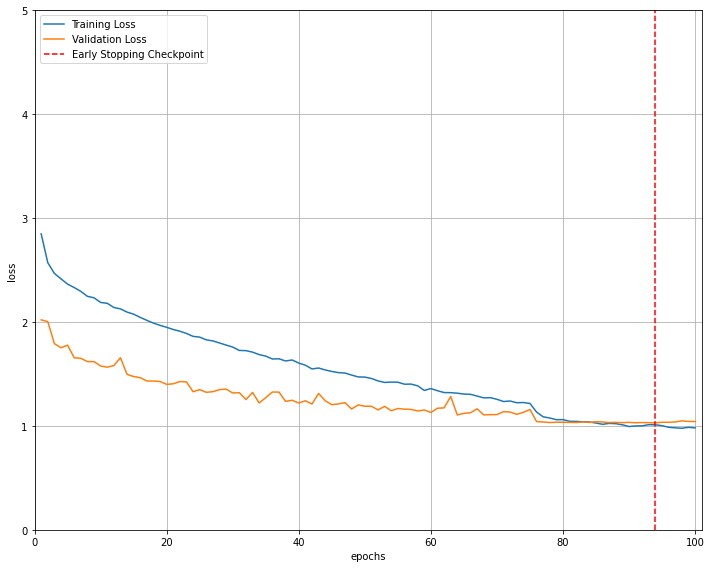

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

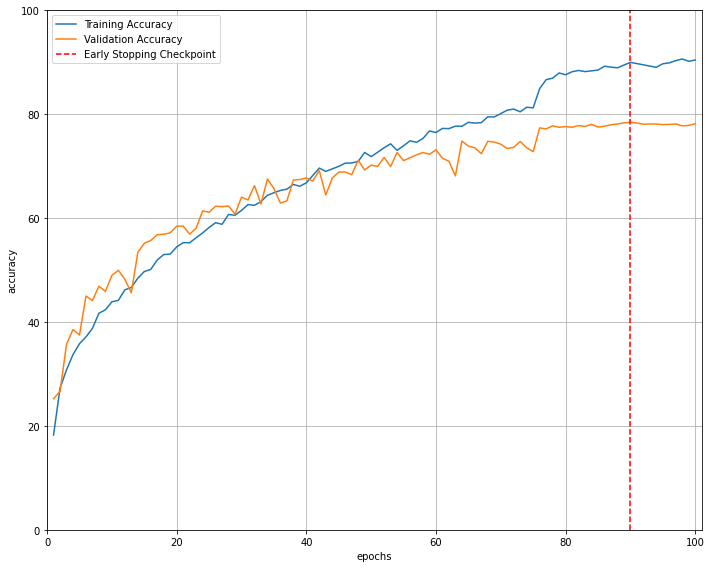

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Validation Accuracy')

# validation Accuracy의 최대값 지점을 찾기
maxposs = val_accuracy.index(max(val_accuracy))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_accuracy)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)

Epoch: 1. Validate.: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


Test Loss: 1.0423, Accuracy: 78.18%


(1.0422979858398438, 78.18)